# Exploración con k-nearest neighbors


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y validación
from sklearn.model_selection import (
    train_test_split,   
    StratifiedKFold,    
    GridSearchCV     
)

# KNN
from sklearn.neighbors import KNeighborsClassifier     

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

df = pd.read_csv('../data/processed/diabetes_sample.csv')
df.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0
1,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,0.0,0.0,0.0,7.0,5.0,8.0
2,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,6.0,8.0
3,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
4,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,8.0


In [2]:
target_col =  'Diabetes_012'
X = df.drop(columns=[target_col])
y = df[target_col]


print("Variables separadas:")
print(f"   X: {X.shape} → {X.shape[1]} features")
print(f"   y: {y.shape} → {y.nunique()} clases")
print(f"Features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

Variables separadas:
   X: (38052, 21) → 21 features
   y: (38052,) → 3 clases
Features:
    1. HighBP
    2. HighChol
    3. CholCheck
    4. BMI
    5. Smoker
    6. Stroke
    7. HeartDiseaseorAttack
    8. PhysActivity
    9. Fruits
   10. Veggies
   11. HvyAlcoholConsump
   12. AnyHealthcare
   13. NoDocbcCost
   14. GenHlth
   15. MentHlth
   16. PhysHlth
   17. DiffWalk
   18. Sex
   19. Age
   20. Education
   21. Income


In [4]:
Y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, 
    random_state=2, 
    stratify=Y
)

print("Datos divididos en entrenamiento y prueba:")
print(f"   X_train: {X_train.shape[0]} samples")   
print(f"   X_test : {X_test.shape[0]} samples")
print(f"   y_train: {Y_train.shape[0]} samples")
print(f"   y_test : {Y_test.shape[0]} samples")

Datos divididos en entrenamiento y prueba:
   X_train: 30441 samples
   X_test : 7611 samples
   y_train: 30441 samples
   y_test : 7611 samples


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model_knn = KNeighborsClassifier()

params_knn = model_knn.get_params()
print("\nParámetros del modelo KNN:")
for param, valor in sorted(params_knn.items()):
    print(f"{param:25s} = {valor}")


Parámetros del modelo KNN:
algorithm                 = auto
leaf_size                 = 30
metric                    = minkowski
metric_params             = None
n_jobs                    = None
n_neighbors               = 5
p                         = 2
weights                   = uniform


In [7]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31],   
    'weights': ['uniform', 'distance'],            
    'p': [1, 2]                                    #(1=Manhattan, 2=Euclídea)
}

# GridSearchCV para KNN
grid_search_knn = GridSearchCV(
    estimator=model_knn,
    param_grid=param_grid_knn,
    scoring='f1_macro',       
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


In [ ]:
print("\nMejores parámetros encontrados:", grid_search_knn.best_params_)
print("Mejor F1 macro en CV:", grid_search_knn.best_score_)

best_knn = grid_search_knn.best_estimator_
print("\nMejor modelo entrenado:\n", best_knn)


Mejores parámetros encontrados: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Mejor F1 macro en CV: 0.3933787548396749

Mejor modelo entrenado:
 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')


In [11]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Seleccionar columnas relevantes
columns_target = [
    'param_n_neighbors',
    'param_weights',
    'param_p',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Subset ordenado por el ranking del score
results_subset_knn = results_knn[columns_target].copy()
results_subset_knn = results_subset_knn.sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")
print(results_subset_knn.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
 param_n_neighbors param_weights  param_p  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
                 3      distance        1          0.994972         0.000917         0.393379        0.006182                1
                 3      distance        2          0.994972         0.000917         0.392392        0.007970                2
                 3       uniform        1          0.536564         0.004126         0.390616        0.004447                3
                 3       uniform        2          0.531924         0.006485         0.387936        0.004797                4
                 5      distance        2          0.994972         0.000917         0.387760        0.006179                5
                 5      distance        1          0.994972         0.000917         0.387354        0.004803                6
                 7      distance        1          0.


Métricas en Test:
Accuracy: 0.8186834844304296
Precision (macro): 0.42483259774567667
Recall (macro): 0.3971394665950169
F1-score (macro): 0.40428581982603706
F1-score (weighted): 0.7992434673727039

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      6412
         1.0       0.03      0.01      0.01       139
         2.0       0.37      0.25      0.30      1060

    accuracy                           0.82      7611
   macro avg       0.42      0.40      0.40      7611
weighted avg       0.78      0.82      0.80      7611



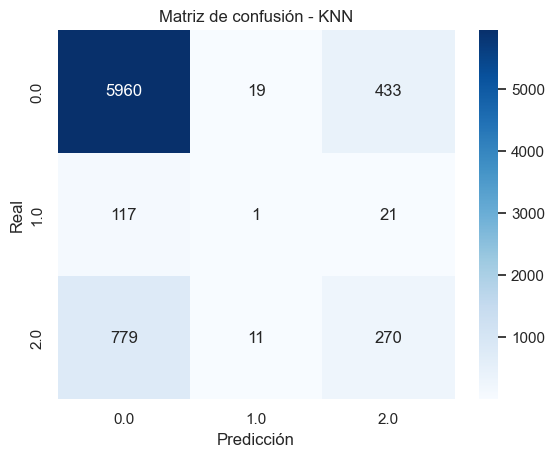

In [12]:
# Predicciones en test
y_pred_knn = best_knn.predict(X_test)

# Métricas en test
print("\nMétricas en Test:")
print("Accuracy:", accuracy_score(Y_test, y_pred_knn))
print("Precision (macro):", precision_score(Y_test, y_pred_knn, average='macro'))
print("Recall (macro):", recall_score(Y_test, y_pred_knn, average='macro'))
print("F1-score (macro):", f1_score(Y_test, y_pred_knn, average='macro'))
print("\nReporte de clasificación:\n", classification_report(Y_test, y_pred_knn))

# Matriz de confusión
cm = confusion_matrix(Y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=np.unique(Y_test),
            yticklabels=np.unique(Y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - KNN")
plt.show()

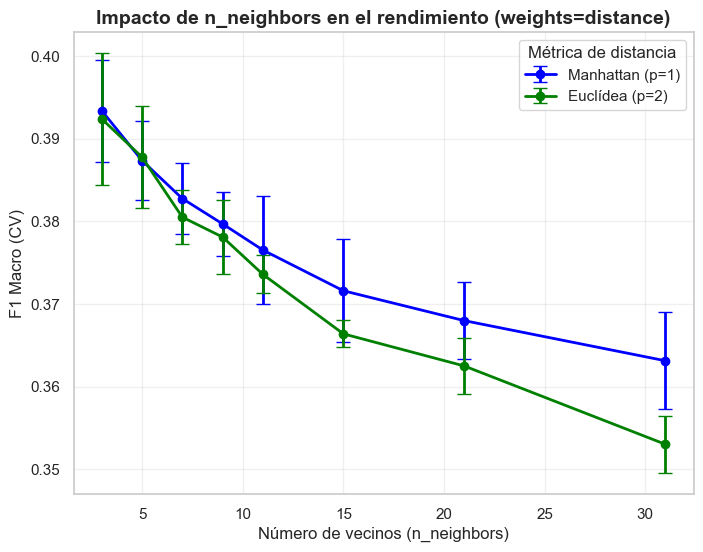

In [16]:
# Filtrar solo los resultados con weights='distance'
data_distance = results_knn[results_knn['param_weights'] == 'distance']

plt.figure(figsize=(8,6))

# Graficar por cada valor de p
for p_value, label, color in [(1, "Manhattan (p=1)", "blue"), (2, "Euclídea (p=2)", "green")]:
    subset = data_distance[data_distance['param_p'] == p_value]
    plt.errorbar(
        subset['param_n_neighbors'],
        subset['mean_test_score'],
        yerr=subset['std_test_score'],
        fmt='o-', capsize=5, linewidth=2, label=label, color=color
    )

plt.xlabel("Número de vecinos (n_neighbors)", fontsize=12)
plt.ylabel("F1 Macro (CV)", fontsize=12)
plt.title("Impacto de n_neighbors en el rendimiento (weights=distance)", fontsize=14, fontweight='bold')
plt.legend(title="Métrica de distancia")
plt.grid(True, alpha=0.3)
plt.show()